In [77]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from numpy import mean, std

In [78]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
    
def get_fiscal_quarter(month):
    if month in [1, 2, 3]:
        return 'Q1'
    elif month in [4, 5, 6]:
        return 'Q2'
    elif month in [7, 8, 9]:
        return 'Q3'
    else:
        return 'Q4'

## Combine Data

In [79]:
car_combined = pd.read_csv('car_combined.cvs')
cpi = pd.read_csv('cpi_processed.cvs')
car_combined.head()

,Car_id,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,...,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,C_CND_000001,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,ford,expedition,Double Overhead Camshaft,Auto,Black,...,6.0,AUTOMATIC,four wheel drive,4.0,Large,4dr SUV,20,15,5657,58185
1,C_CND_000001,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,ford,expedition,Double Overhead Camshaft,Auto,Black,...,6.0,AUTOMATIC,rear wheel drive,4.0,Large,4dr SUV,21,15,5657,62025
2,C_CND_000001,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,ford,expedition,Double Overhead Camshaft,Auto,Black,...,6.0,AUTOMATIC,rear wheel drive,4.0,Large,4dr SUV,21,15,5657,62985
3,C_CND_000001,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,ford,expedition,Double Overhead Camshaft,Auto,Black,...,6.0,AUTOMATIC,rear wheel drive,4.0,Large,4dr SUV,22,16,5657,59375
4,C_CND_000001,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,ford,expedition,Double Overhead Camshaft,Auto,Black,...,6.0,AUTOMATIC,four wheel drive,4.0,Large,4dr SUV,20,14,5657,66025


In [80]:
cpi.head()

,CPI,Year,Month,Day
0,21.48,1947,1,1
1,21.62,1947,2,1
2,22.00,1947,3,1
3,22.00,1947,4,1
4,21.95,1947,5,1


Combine datasets into one dataset. We will join on date.

In [81]:
complete_df = pd.merge(car_combined, cpi, left_on=['Year_x', 'Month', 'Day'], right_on=['Year', 'Month', 'Day'], how='inner')
complete_df.head()

,Car_id,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,...,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,CPI,Year
0,C_CND_000636,Mila,Female,671500,Scrivener Performance Engineering,toyota,sienna,Overhead Camshaft,Manual,Pale White,...,all wheel drive,4.0,Large,Passenger Minivan,23,16,2031,42880,287.553,2022
1,C_CND_000636,Mila,Female,671500,Scrivener Performance Engineering,toyota,sienna,Overhead Camshaft,Manual,Pale White,...,all wheel drive,4.0,Large,Passenger Minivan,23,16,2031,37400,287.553,2022
2,C_CND_000636,Mila,Female,671500,Scrivener Performance Engineering,toyota,sienna,Overhead Camshaft,Manual,Pale White,...,all wheel drive,4.0,Large,Passenger Minivan,23,16,2031,40655,287.553,2022
3,C_CND_000636,Mila,Female,671500,Scrivener Performance Engineering,toyota,sienna,Overhead Camshaft,Manual,Pale White,...,front wheel drive,4.0,Large,Passenger Minivan,25,18,2031,37445,287.553,2022
4,C_CND_000636,Mila,Female,671500,Scrivener Performance Engineering,toyota,sienna,Overhead Camshaft,Manual,Pale White,...,front wheel drive,4.0,Large,Passenger Minivan,25,18,2031,35200,287.553,2022


In [82]:
columns = complete_df.columns.to_list()
print(columns)

['Car_id', 'Customer Name', 'Gender', 'Annual Income', 'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Price', 'Dealer_No ', 'Body Style', 'Phone', 'Dealer_Region', 'Month', 'Day', 'Year_x', 'Make', 'Year_y', 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Driven_Wheels', 'Number of Doors', 'Vehicle Size', 'Vehicle Style', 'highway MPG', 'city mpg', 'Popularity', 'MSRP', 'CPI', 'Year']


Some of these columns will not be helpful for data mining. We will drop the unecessary columns. There are three ambiguously named 'Year' columns. We will drop one of the two which represent the year of the sale and rename the columns to 'Manufacture_Year', and 'Sale_Year' to more clearly indicate the content of these columns.

In [83]:
columns_to_drop = ['Car_id', 'Dealer_No ', 'Year_x', 'Customer Name', 'Phone']
complete_df.drop(columns_to_drop, axis=1, inplace=True)
complete_df = complete_df.rename(columns={'Year_y':'Manufacture_Year', 'Year':'Sale_Year'})

## Data Exploration and Summarization

We will investigate the distribution of the data using histograms.

In [84]:
complete_df['Day'].nunique()

1

array([[<Axes: title={'center': 'Annual Income'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>],
       [<Axes: title={'center': 'Manufacture_Year'}>,
        <Axes: title={'center': 'Engine HP'}>,
        <Axes: title={'center': 'Engine Cylinders'}>,
        <Axes: title={'center': 'Number of Doors'}>],
       [<Axes: title={'center': 'highway MPG'}>,
        <Axes: title={'center': 'city mpg'}>,
        <Axes: title={'center': 'Popularity'}>,
        <Axes: title={'center': 'MSRP'}>],
       [<Axes: title={'center': 'CPI'}>,
        <Axes: title={'center': 'Sale_Year'}>, <Axes: >, <Axes: >]],
      dtype=object)

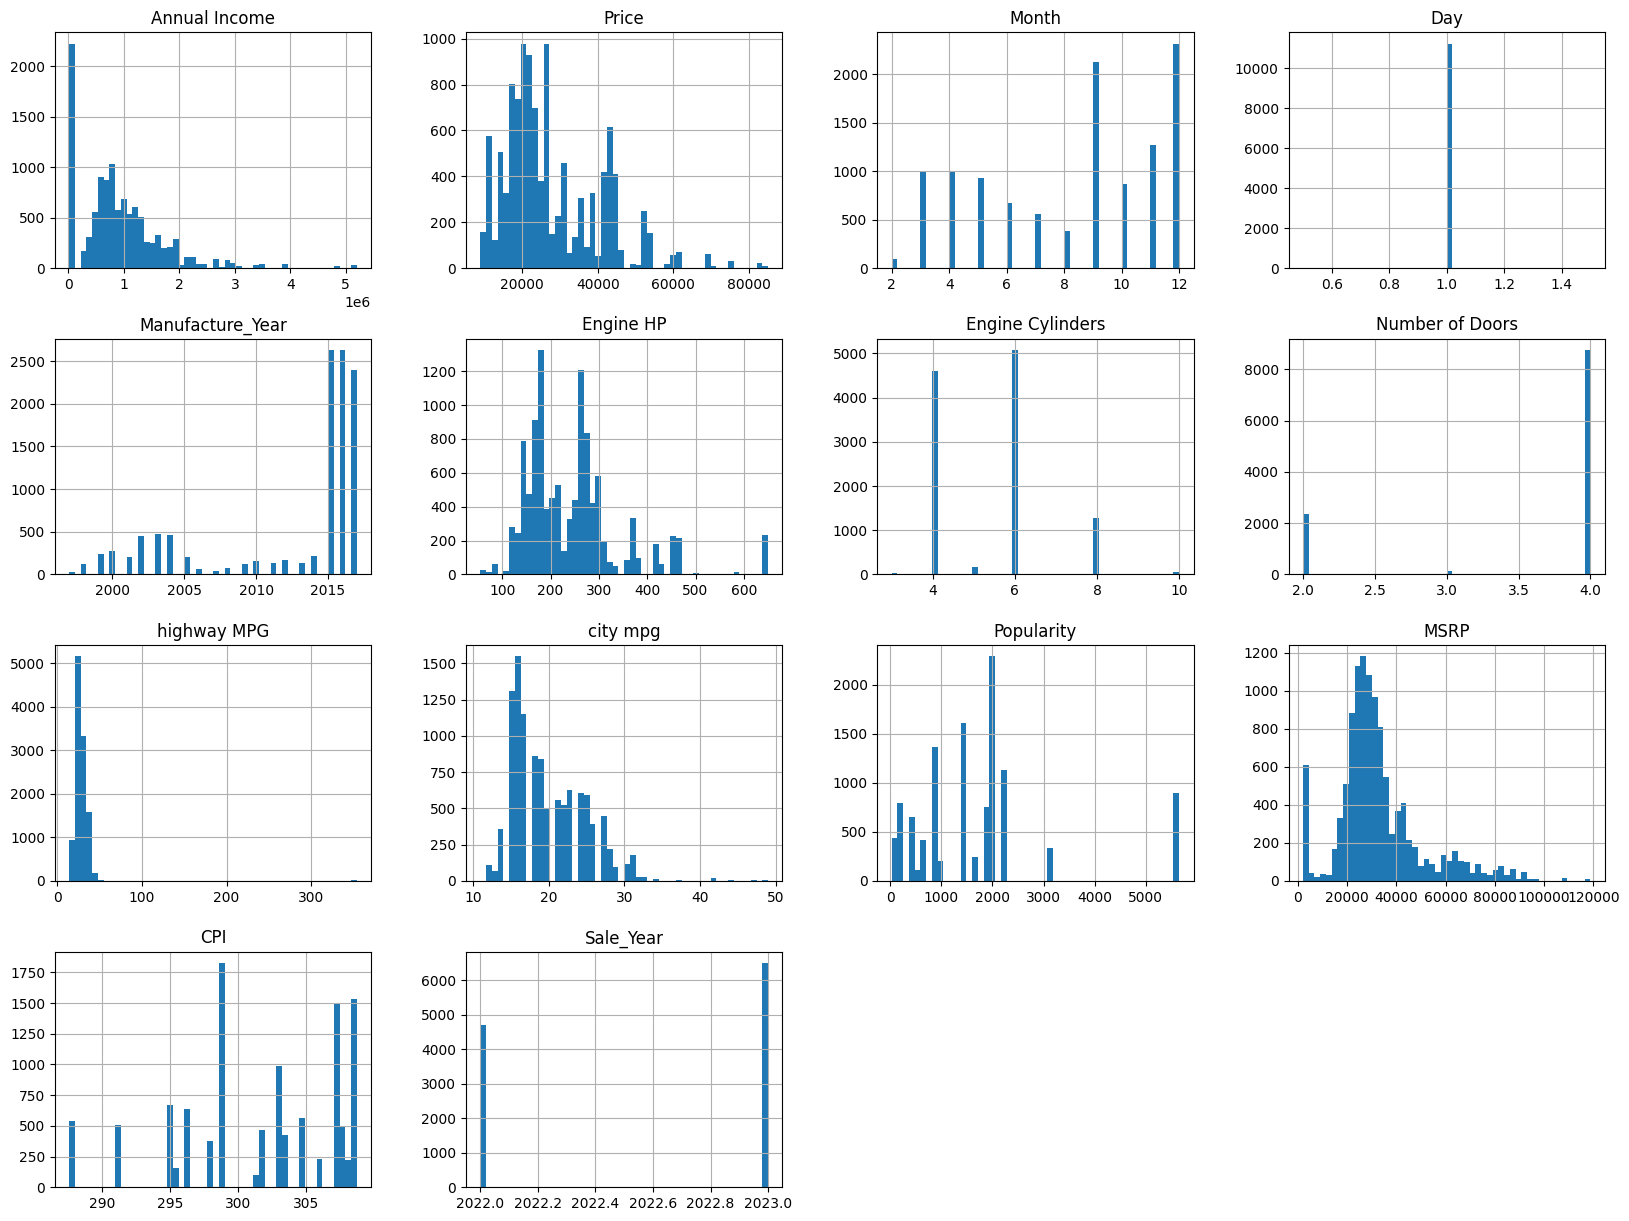

In [85]:
complete_df.hist(bins = 50, figsize=(20,15))

We will use a heatmap to investigate the coorelation between columns.

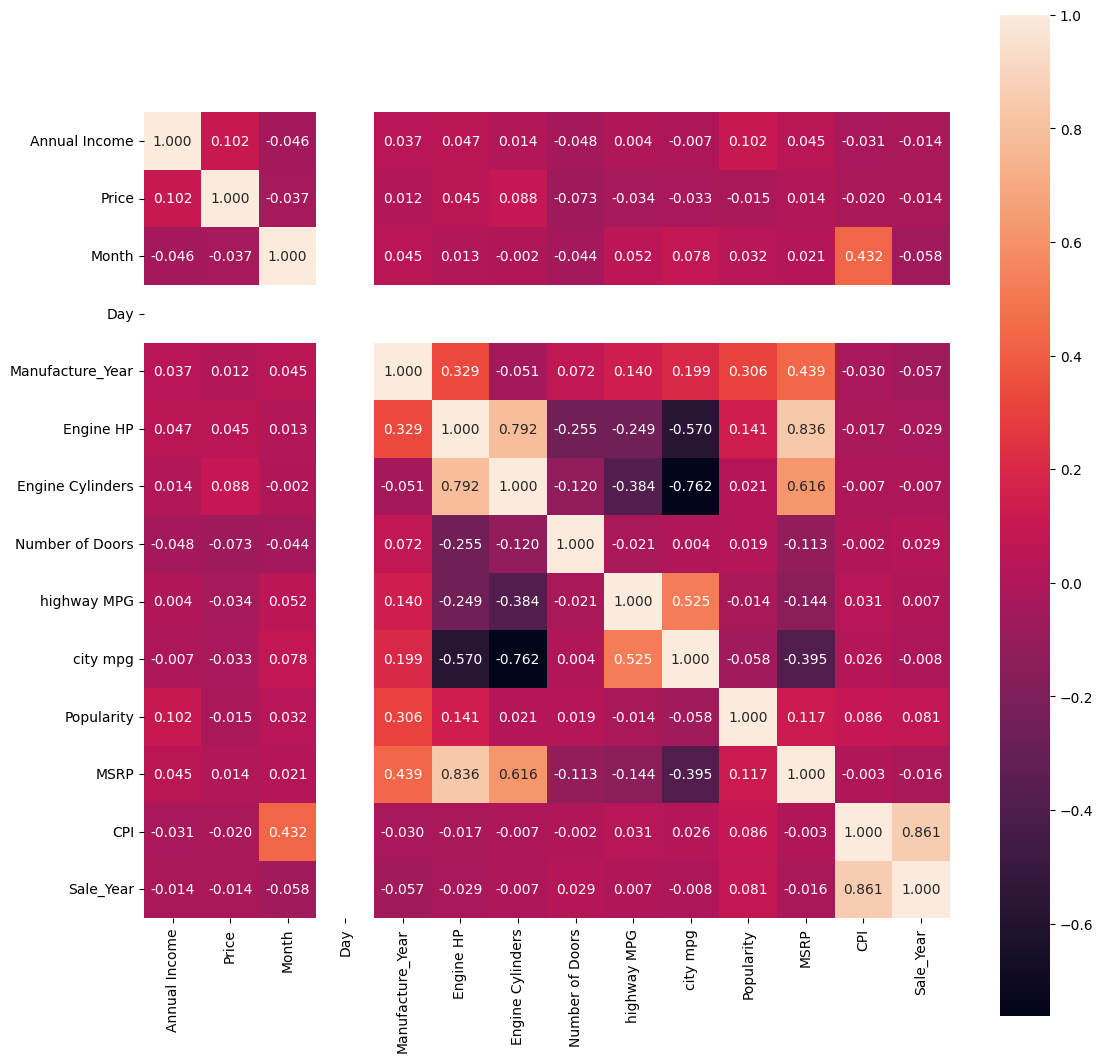

In [86]:
numeric_df = complete_df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()
f,ax = plt.subplots(figsize=(13, 13))
sns.heatmap(numeric_df.corr(), annot=True, square=True , fmt = ".3f")
plt.show()

## Preprocessing

In [87]:
def one_hot_encode(dataframe, columns):
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(dataframe[columns])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(columns))
    dataframe.drop(columns, axis=1, inplace=True)
    return pd.concat([dataframe, encoded_df], axis=1)

def label_encode(dataframe, columns):
    encoder = LabelEncoder()
    for column in columns:
        dataframe[column] = encoder.fit_transform(dataframe[column])
    return dataframe

def frequency_encode(dataframe, columns):
    for column in columns:
        frequency = dataframe[column].value_counts(normalize=True)
        dataframe[column + '_freq_encoded'] = dataframe[column].map(frequency)
    return dataframe

def standardize_cols(dataframe, columns):
    scaler = StandardScaler()
    for column in columns:
        dataframe[column + '_standardized'] = scaler.fit_transform(dataframe[[column]])
        dataframe.drop(column, axis=1, inplace=True)
    return dataframe

def normalize_numeric_data(dataframe, columns):
    for column in columns:
        min_val = dataframe[column].min()
        max_val = dataframe[column].max()
        dataframe[column + '_normalized'] = (dataframe[column] - min_val) / (max_val - min_val)
    return dataframe


In [88]:
columns = ['Make', 'Model', 'Dealer_Region', 'Dealer_Name']

for column in columns:
    print(column, "unique values: ", complete_df[column].nunique(), "\n")

Make unique values:  22 

Model unique values:  112 

Dealer_Region unique values:  7 

Dealer_Name unique values:  28 



In [89]:
one_hot_columns = ['Gender', 'Engine', 'Transmission', 'Color', 'Body Style', 'Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Style', 'Dealer_Region']
label_columns = ['Vehicle Size']
numerical_columns = ['Annual Income', 'Price', 'highway MPG', 'city mpg', 'Popularity', 'MSRP', 'CPI', 'Manufacture_Year', 'Sale_Year']

In [90]:
processed_df = one_hot_encode(complete_df, one_hot_columns)
processed_df = label_encode(processed_df, label_columns)

In [91]:
processed_df_n = processed_df.copy()
processed_df = standardize_cols(processed_df, numerical_columns)
numerical_columns_standardized = [column + '_standardized' for column in numerical_columns]


## Random Forest Algorithm

Using a random forest algorithm to guess the car that was sold

### One Hot Encode to use data

In [92]:
# See what columns are unnecessary and drop
complete_df.columns


Index(['Annual Income', 'Dealer_Name', 'Company', 'Model', 'Price', 'Month',
       'Day', 'Make', 'Manufacture_Year', 'Engine HP', 'Engine Cylinders',
       'Number of Doors', 'Vehicle Size', 'highway MPG', 'city mpg',
       'Popularity', 'MSRP', 'CPI', 'Sale_Year'],
      dtype='object')

In [93]:
y = complete_df['Model']
X = complete_df.drop(['Company', 'Model'], axis=1)
X.head()

,Annual Income,Dealer_Name,Price,Month,Day,Make,Manufacture_Year,Engine HP,Engine Cylinders,Number of Doors,Vehicle Size,highway MPG,city mpg,Popularity,MSRP,CPI,Sale_Year
0,671500,Scrivener Performance Engineering,39501,3,1,toyota,2015,266.0,6.0,4.0,Large,23,16,2031,42880,287.553,2022
1,671500,Scrivener Performance Engineering,39501,3,1,toyota,2015,266.0,6.0,4.0,Large,23,16,2031,37400,287.553,2022
2,671500,Scrivener Performance Engineering,39501,3,1,toyota,2015,266.0,6.0,4.0,Large,23,16,2031,40655,287.553,2022
3,671500,Scrivener Performance Engineering,39501,3,1,toyota,2015,266.0,6.0,4.0,Large,25,18,2031,37445,287.553,2022
4,671500,Scrivener Performance Engineering,39501,3,1,toyota,2015,266.0,6.0,4.0,Large,25,18,2031,35200,287.553,2022


In [94]:
X = X.drop(['Make', 'Dealer_Name', 'Annual Income', 'Sale_Year', 'Month', 'Day'], axis=1)
X.head()

,Price,Manufacture_Year,Engine HP,Engine Cylinders,Number of Doors,Vehicle Size,highway MPG,city mpg,Popularity,MSRP,CPI
0,39501,2015,266.0,6.0,4.0,Large,23,16,2031,42880,287.553
1,39501,2015,266.0,6.0,4.0,Large,23,16,2031,37400,287.553
2,39501,2015,266.0,6.0,4.0,Large,23,16,2031,40655,287.553
3,39501,2015,266.0,6.0,4.0,Large,25,18,2031,37445,287.553
4,39501,2015,266.0,6.0,4.0,Large,25,18,2031,35200,287.553


In [95]:
# See what updated columns need to be one hot encoded after dropping unnecessary
oneHotTargets = X.select_dtypes(include=['object']).columns
oneHotTargets

Index(['Vehicle Size'], dtype='object')

In [96]:
# One Hot Encode columns
oneHotTargetValues = X[oneHotTargets]  # Get text data values

oneHotEncodedData = pd.get_dummies(oneHotTargetValues).astype(int)

oneHotEncodedData

,Vehicle Size_Compact,Vehicle Size_Large,Vehicle Size_Midsize
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
11217,1,0,0
11218,1,0,0
11219,0,0,1
11220,0,0,1


In [97]:
# Concatonate back into dataframe
X = pd.concat([X.drop(oneHotTargets, axis=1), oneHotEncodedData], axis=1)
X.head()

,Price,Manufacture_Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,CPI,Vehicle Size_Compact,Vehicle Size_Large,Vehicle Size_Midsize
0,39501,2015,266.0,6.0,4.0,23,16,2031,42880,287.553,0,1,0
1,39501,2015,266.0,6.0,4.0,23,16,2031,37400,287.553,0,1,0
2,39501,2015,266.0,6.0,4.0,23,16,2031,40655,287.553,0,1,0
3,39501,2015,266.0,6.0,4.0,25,18,2031,37445,287.553,0,1,0
4,39501,2015,266.0,6.0,4.0,25,18,2031,35200,287.553,0,1,0


In [98]:
y

0        sienna
1        sienna
2        sienna
3        sienna
4        sienna
          ...  
11217     metro
11218     metro
11219    cirrus
11220    cirrus
11221    cirrus
Name: Model, Length: 11222, dtype: object

In [99]:
# Multiclass convert string labels to integers
class_encoder = LabelEncoder()

y = class_encoder.fit_transform(y)

In [100]:
# Prepare data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes
print("Shapes")
print("=======")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes
X_train: (8977, 13)
X_test: (2245, 13)
y_train: (8977,)
y_test: (2245,)


In [101]:
# Make model and train
randomForest = RandomForestClassifier(n_estimators=100, random_state=None)

randomForest.fit(X_train, y_train)


RandomForestClassifier()

In [102]:
# Predict and evaluate

# Note: KFold cross validation gives warnings due to insufficient data for the folds

y_pred = randomForest.predict(X_test)

# Evaluate the model with weighted averages
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation scores
print("Weighted Averages")
print("=================")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Weighted Averages
Accuracy: 0.9991091314031181
Precision: 0.9984409799554566
Recall: 0.9991091314031181
F1-score: 0.9987273305758828


c:\Users\Angus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [103]:
# Evaluate the model with Micro Averages
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

# Print the evaluation scores
print("Micro Averages")
print("=================")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Micro Averages
Accuracy: 0.9991091314031181
Precision: 0.9991091314031181
Recall: 0.9991091314031181
F1-score: 0.9991091314031181


In [104]:
# Evaluate the model with Macro Averages
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation scores
print("Macro Averages")
print("=================")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Macro Averages
Accuracy: 0.9991091314031181
Precision: 0.9886363636363636
Recall: 0.990909090909091
F1-score: 0.9896103896103896


c:\Users\Angus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
